In [2]:
import numpy as np
import qiskit as qis

from numpy.random import default_rng

from qiskit.exceptions import QiskitError
from qiskit.quantum_info.operators.random import * 
from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import *
from qiskit.primitives import Sampler

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error)
#from qiskit.extensions import Initialize

from matplotlib.pyplot import figure



%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\ipobo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In this part I was trying the rotation operator that biases the distributions by rotation. This will help us show a much more realistic picture, as some of the logical connectives will hold higher weight than others.This will shift the hard logical network to a softer more realistic logic.

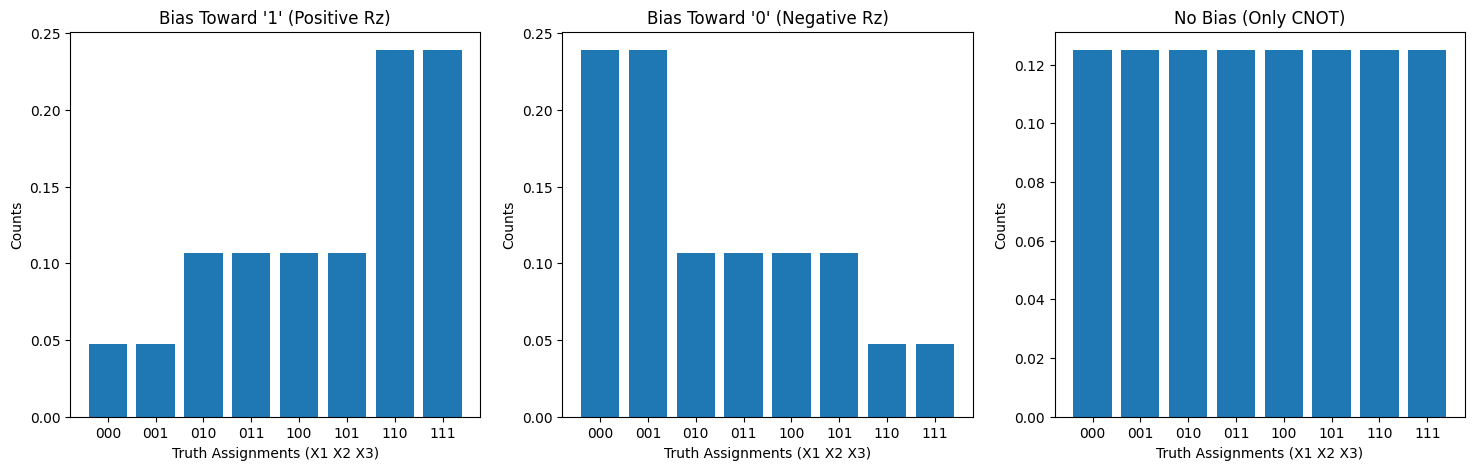

Circuit with positive Rz gates (favoring 1s):
     ┌───┐                                ┌─┐      
q_0: ┤ H ├──■───────────────■─────────────┤M├──────
     ├───┤┌─┴─┐┌─────────┐  │             └╥┘┌─┐   
q_1: ┤ H ├┤ X ├┤ Ry(π/8) ├──■──────────────╫─┤M├───
     ├───┤└───┘└─────────┘┌─┴─┐┌─────────┐ ║ └╥┘┌─┐
q_2: ┤ H ├────────────────┤ X ├┤ Ry(π/8) ├─╫──╫─┤M├
     └───┘                └───┘└─────────┘ ║  ║ └╥┘
c: 3/══════════════════════════════════════╩══╩══╩═
                                           0  1  2 

Circuit with negative Rz gates (favoring 0s):
     ┌───┐                                  ┌─┐      
q_0: ┤ H ├──■────────────────■──────────────┤M├──────
     ├───┤┌─┴─┐┌──────────┐  │              └╥┘┌─┐   
q_1: ┤ H ├┤ X ├┤ Ry(-π/8) ├──■───────────────╫─┤M├───
     ├───┤└───┘└──────────┘┌─┴─┐┌──────────┐ ║ └╥┘┌─┐
q_2: ┤ H ├─────────────────┤ X ├┤ Ry(-π/8) ├─╫──╫─┤M├
     └───┘                 └───┘└──────────┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════╩══╩══╩═
       

In [13]:


# Define MLN weights (how much we care about the logical formula being true)
w1 = math.pi / 8  # Weight for X1 => X2
w2 = math.pi / 8  # Weight for X2 => X3

# Create quantum circuits
circuit_pos_rz = QuantumCircuit(3, 3)  # Bias towards '1'
circuit_neg_rz = QuantumCircuit(3, 3)  # Bias towards '0'
circuit_no_rz = QuantumCircuit(3, 3)  # No bias

# Step 1: Put all qubits in superposition (representing all truth assignments)
circuit_pos_rz.h([0, 1, 2])
circuit_neg_rz.h([0, 1, 2])
circuit_no_rz.h([0, 1, 2])

# Step 2: Apply logical constraints using CNOT gates
circuit_pos_rz.cx(0, 1)  # X1 => X2
circuit_pos_rz.ry(w1, 1)  # Apply weighted phase shift to X2
circuit_pos_rz.ccx(0, 1, 2)  # X2 => X3
circuit_pos_rz.ry(w2, 2)  # Apply weighted phase shift to X3

circuit_neg_rz.cx(0, 1)  # X1 => X2
circuit_neg_rz.ry(-w1, 1)  # Apply negative phase shift to X2
circuit_neg_rz.ccx(0, 1, 2)  # X2 => X3
circuit_neg_rz.ry(-w2, 2)  # Apply negative phase shift to X3

# Apply only CNOT gates to the third circuit (no phase biasing)
circuit_no_rz.cx(0, 1)
circuit_no_rz.ccx(0, 1, 2)

# Step 3: Measure all qubits
circuit_pos_rz.measure([0, 1, 2], [0, 1, 2])
circuit_neg_rz.measure([0, 1, 2], [0, 1, 2])
circuit_no_rz.measure([0, 1, 2], [0, 1, 2])

def run_circuit(qc):
    results = Sampler().run(qc).result()
    counts = results.quasi_dists[0].binary_probabilities()

    return counts

counts_pos_rz = run_circuit(circuit_pos_rz)
counts_neg_rz = run_circuit(circuit_neg_rz)
counts_no_rz = run_circuit(circuit_no_rz)

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].bar(counts_pos_rz.keys(), counts_pos_rz.values())
axes[0].set_xlabel("Truth Assignments (X1 X2 X3)")
axes[0].set_ylabel("Counts")
axes[0].set_title("Bias Toward '1' (Positive Rz)")

axes[1].bar(counts_neg_rz.keys(), counts_neg_rz.values())
axes[1].set_xlabel("Truth Assignments (X1 X2 X3)")
axes[1].set_ylabel("Counts")
axes[1].set_title("Bias Toward '0' (Negative Rz)")

axes[2].bar(counts_no_rz.keys(), counts_no_rz.values())
axes[2].set_xlabel("Truth Assignments (X1 X2 X3)")
axes[2].set_ylabel("Counts")
axes[2].set_title("No Bias (Only CNOT)")

plt.show()

# Display the quantum circuits
print("Circuit with positive Rz gates (favoring 1s):")
print(circuit_pos_rz.draw())
print("\nCircuit with negative Rz gates (favoring 0s):")
print(circuit_neg_rz.draw())
print("\nCircuit without Rz gates (neutral):")
print(circuit_no_rz.draw())


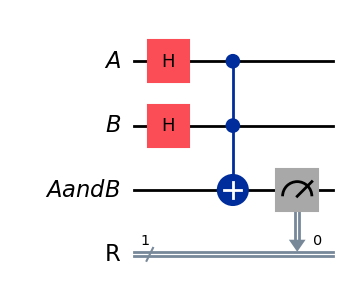

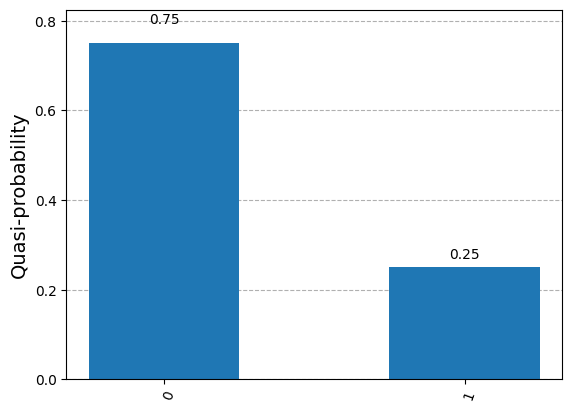

In [3]:
A = qis.QuantumRegister(1, "A")
B =  qis.QuantumRegister(1, "B")
AandB =  qis.QuantumRegister(1, "AandB")

R = qis.ClassicalRegister(1, "R")

neg_circ = QuantumCircuit(A, B, AandB, R)

neg_circ.h(A)
neg_circ.h(B)
neg_circ.ccx(A, B, AandB)
neg_circ.measure(AandB, R)
display(neg_circ.draw('mpl'))

results = Sampler().run(neg_circ).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

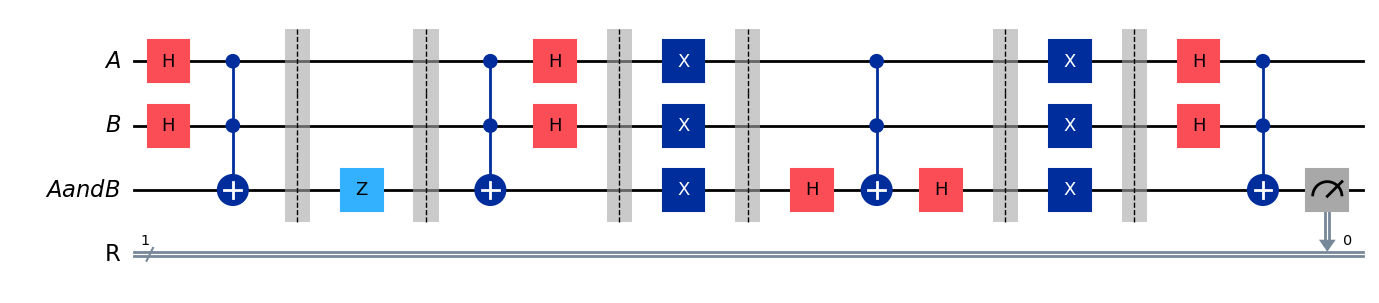

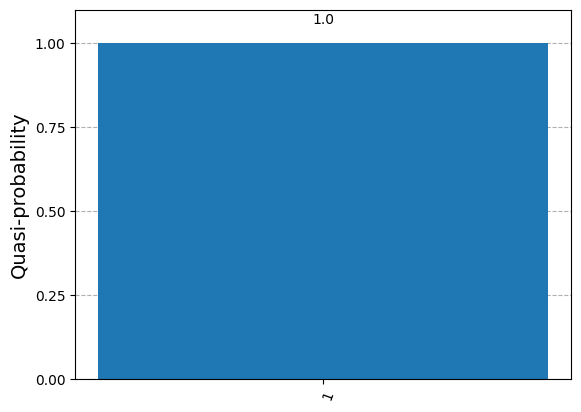

In [14]:
A = qis.QuantumRegister(1, "A")
B =  qis.QuantumRegister(1, "B")
AandB =  qis.QuantumRegister(1, "AandB")

R = qis.ClassicalRegister(1, "R")

neg_circ = QuantumCircuit(A, B, AandB, R)

neg_circ.h(A)
neg_circ.h(B)
neg_circ.ccx(A, B, AandB)

neg_circ.barrier()

neg_circ.z(AandB)

neg_circ.barrier()

neg_circ.ccx(A, B, AandB)
neg_circ.h(A)
neg_circ.h(B)

neg_circ.barrier()



neg_circ.x(A)
neg_circ.x(B)
neg_circ.x(AandB)

neg_circ.barrier()

neg_circ.h(AandB)
neg_circ.ccx(A, B, AandB)
neg_circ.h(AandB)

neg_circ.barrier()

neg_circ.x(A)
neg_circ.x(B)
neg_circ.x(AandB)



neg_circ.barrier()

neg_circ.h(A)
neg_circ.h(B)
neg_circ.ccx(A, B, AandB)

neg_circ.measure(AandB, R)
display(neg_circ.draw('mpl'))

results = Sampler().run(neg_circ).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))